Common date columns: ['2017-09-05', '2017-09-09', '2017-10-21', '2018-01-05', '2018-01-09', '2018-01-19', '2018-01-20', '2018-02-02', '2018-03-06', '2018-03-16', '2018-03-18', '2018-03-20', '2018-03-21', '2018-03-23', '2018-03-24', '2018-04-02', '2018-04-03', '2018-04-10', '2018-04-13', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-20', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-05', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-31', '2018-06-01', '2018-06-09', '2018-06-10', '2018-06-14', '2018-06-16', '2018-06-17', '2018-06-19', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-26', '2018-07-02', '2018-07-03', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-15', '2018-07-17', '2018-07-27', '2018-08-06', '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-27', '2018-09-01', '2018-09-02', '2018-09-06', '2018-09-07', '2018-09-09', '2018-09-10', '2018-09-11', '2018-09-17', '2018-09-18', '2018-09-20', '2018-09-21', '2018-09-24', '2018-09-25'

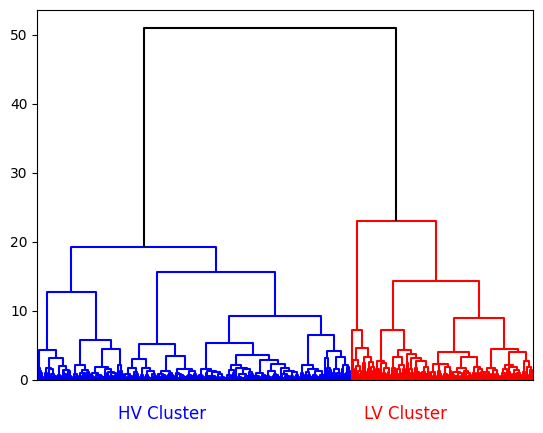

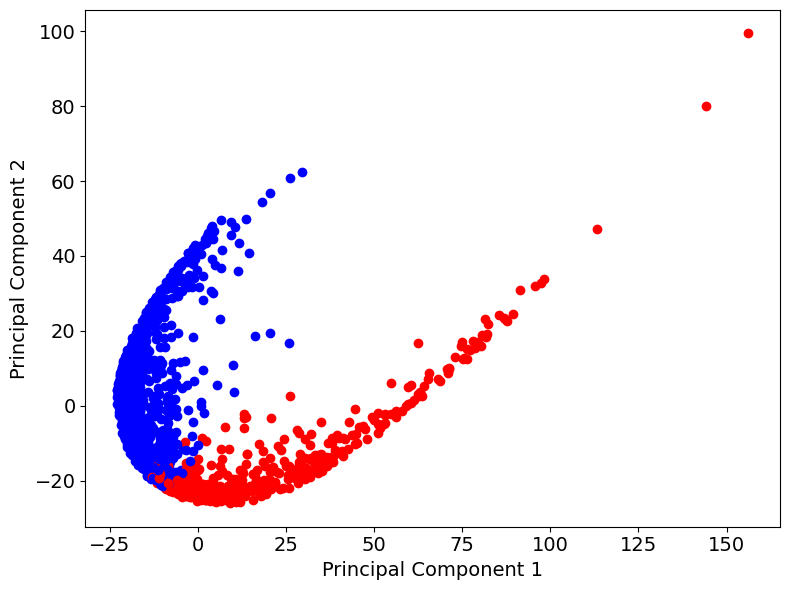

In [1]:
for name in list(globals()):
    if not name.startswith('_'):
        del globals()[name]


import pandas as pd
import os
import numpy as np 
from scipy.stats.mstats import gmean
import scipy
from scipy.spatial import distance_matrix
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cut_tree
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from cycler import cycler

# =======================================================
# Load the Q vectors and find common columns
# =======================================================

# Get the default property cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Set the first three colors to orange, blue, and red, respectively
new_colors = ['#000000', '#0000FF', '#FF0000'] + default_colors[3:]
# Set the new property cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=new_colors)
#path="/Users/ratmir/Desktop/Clustering Zijin New"
path="/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(path)
multivariate_cluster_path = os.path.join(path, "Clustering", "Tau-independent", "unique", "moneyness_step_0d01","multivariate_clustering_9_27_45")
os.makedirs(multivariate_cluster_path, exist_ok=True)
# Load the Q vectors from the four different time-to-maturity (ttm) periods
df1 = pd.read_csv(os.path.join(path, "Q_matrix", "Tau-independent", "unique", "moneyness_step_0d01",'Q_matrix_9day_d15.csv'))
df2 = pd.read_csv(os.path.join(path, "Q_matrix", "Tau-independent", "unique", "moneyness_step_0d01",'Q_matrix_27day_d15.csv'))
df3 = pd.read_csv(os.path.join(path, "Q_matrix", "Tau-independent", "unique", "moneyness_step_0d01",'Q_matrix_45day_d15.csv'))
# Get the column names from each DataFrame
columns1 = list(df1.columns)[1:]
columns2 = list(df2.columns)[1:]
columns3 = list(df3.columns)[1:]

# Find common columns, preserving the order based on the first DataFrame
common_columns = [col for col in columns1 if col in columns2 and col in columns3]
# Print all column lists and the common columns
print("Common date columns:", common_columns)

# =======================================================
# CLR Transformation as the paper: log(x) - log(gmean(x))
# =======================================================
def clr(x):
   return np.log(x) - np.log(gmean(x))
df1_clr = clr(df1.drop(['Return'], axis=1))
df2_clr = clr(df2.drop(['Return'], axis=1))
df3_clr = clr(df3.drop(['Return'], axis=1))

# =====================================================================================================================
# Calculate the pairwise multivariate Euclidean distances between the rows of this new matrix. Do the clustering.
# =====================================================================================================================
concatenated_vectors = []
# Loop through each common date
for date in common_columns:
   # Extract the columns (returns for the given date) from each DataFrame
   print(date)
   vec1 = df1_clr[date].to_numpy()
   vec2 = df2_clr[date].to_numpy()
   vec3 = df3_clr[date].to_numpy()

   # Concatenate the four vectors to form a single multivariate observation for that date
   concatenated_vector = np.concatenate((vec1, vec2, vec3))

   # Append this concatenated vector to the list
   concatenated_vectors.append(concatenated_vector)
concatenated_matrix = np.array(concatenated_vectors)
distance_matrix_flat = scipy.spatial.distance.pdist(concatenated_matrix, 'euclidean')
Z = sch.linkage(distance_matrix_flat, method='ward')
cluster_labels = cut_tree(Z, height=40).T # The height has to be updated accordingly

# =======================
# Plot the dendrogram
# =======================
dendrogram_data = sch.dendrogram(Z)
plt.xticks([])
# Get the x-coordinates of the leaves (i.e., the original observations)
leaf_x_positions = dendrogram_data['icoord']
# Calculate mean x-position for each cluster's leaves to find a representative x-position for the cluster label
mean_x_positions = [np.mean(xs) for xs in leaf_x_positions]
cluster_0_x_pos = np.mean(mean_x_positions[:len(mean_x_positions)//2])
cluster_1_x_pos = np.mean(mean_x_positions[len(mean_x_positions)//2:])
# Add custom labels "C0" and "C1" at the data-driven x-positions
plt.text(x=cluster_0_x_pos, y=-5, s="HV Cluster", ha='center', va='center', fontsize=12, color='blue')
plt.text(x=cluster_1_x_pos, y=-5, s="LV Cluster ", ha='center', va='center', fontsize=12, color='red')
plt.savefig(os.path.join(multivariate_cluster_path, "dendrogram.png"))
plt.show()
ss= cut_tree(Z, n_clusters = 2).T
np.unique(ss, return_counts=True)

# =======================================
# PCA ANALSIS OF THE DISTANCE MATRIX
# =======================================

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
dist_matrix = squareform(pdist(concatenated_matrix, 'euclidean'))
# 2D plot of the principal components of the distance matrix
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist_matrix)
# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Plotting the 2D principal components
plt.figure(figsize=(8, 6))
colors = ['blue', 'red']  # Define colors for each cluster
labels = ['HV Cluster', 'LV Cluster']  # Custom labels for each cluster

cluster_labels = np.array(cluster_labels).flatten()  # Convert cluster_labels to a 1D array
for i in range(len(X_pca)):
    cluster_idx = cluster_labels[i]
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=colors[cluster_idx], label=labels[cluster_idx])
# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
print(len(common_columns))

1065


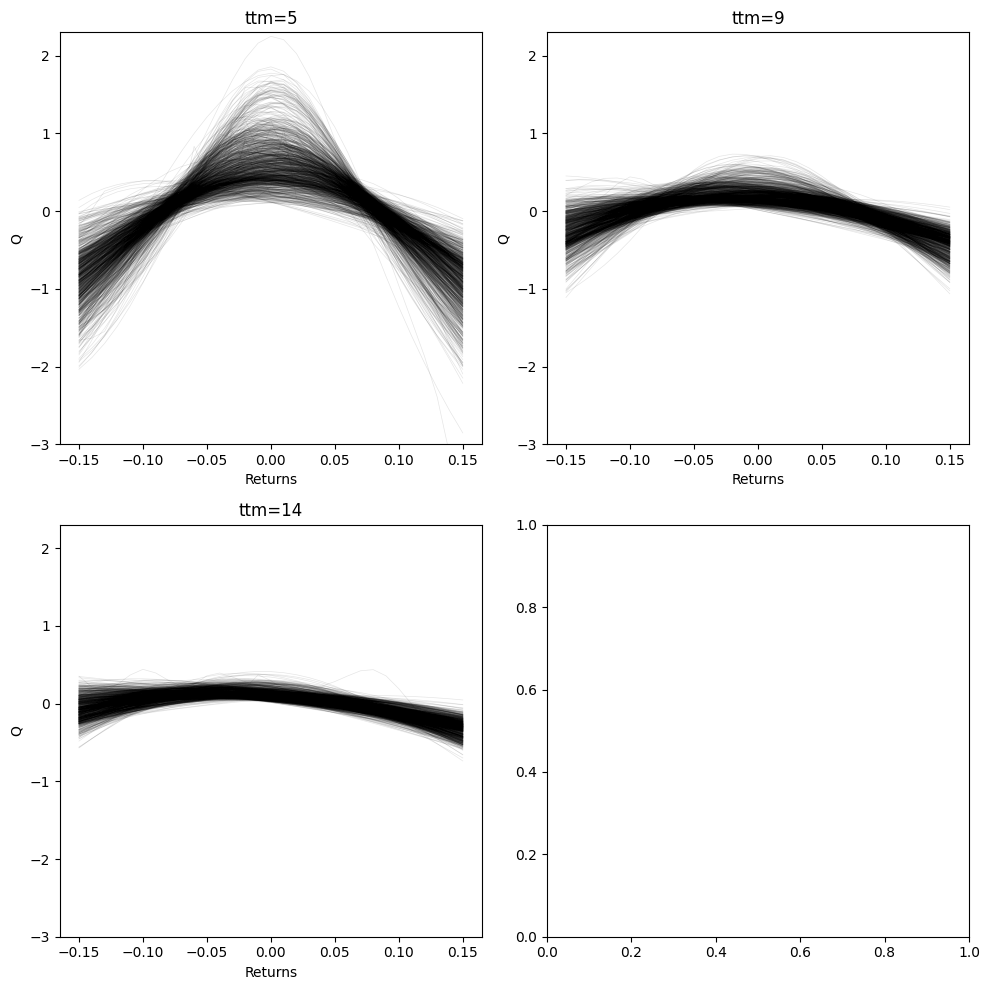

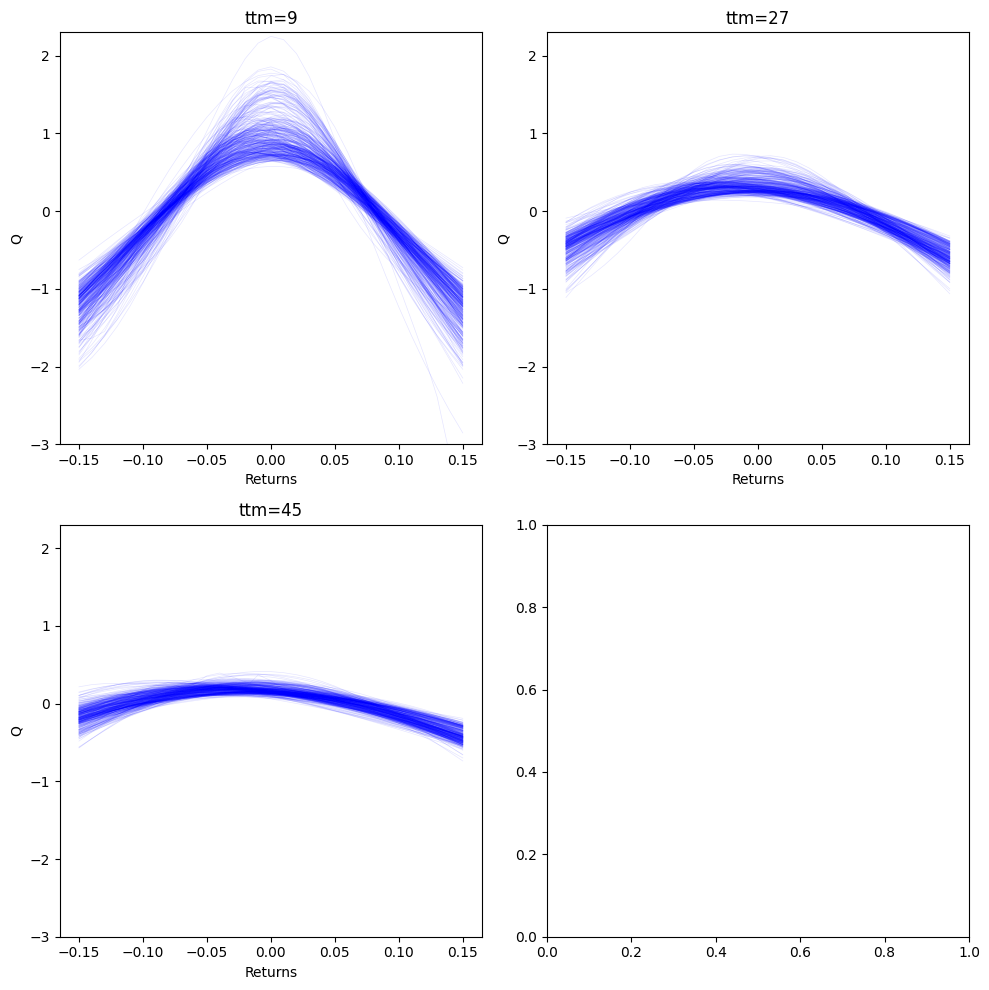

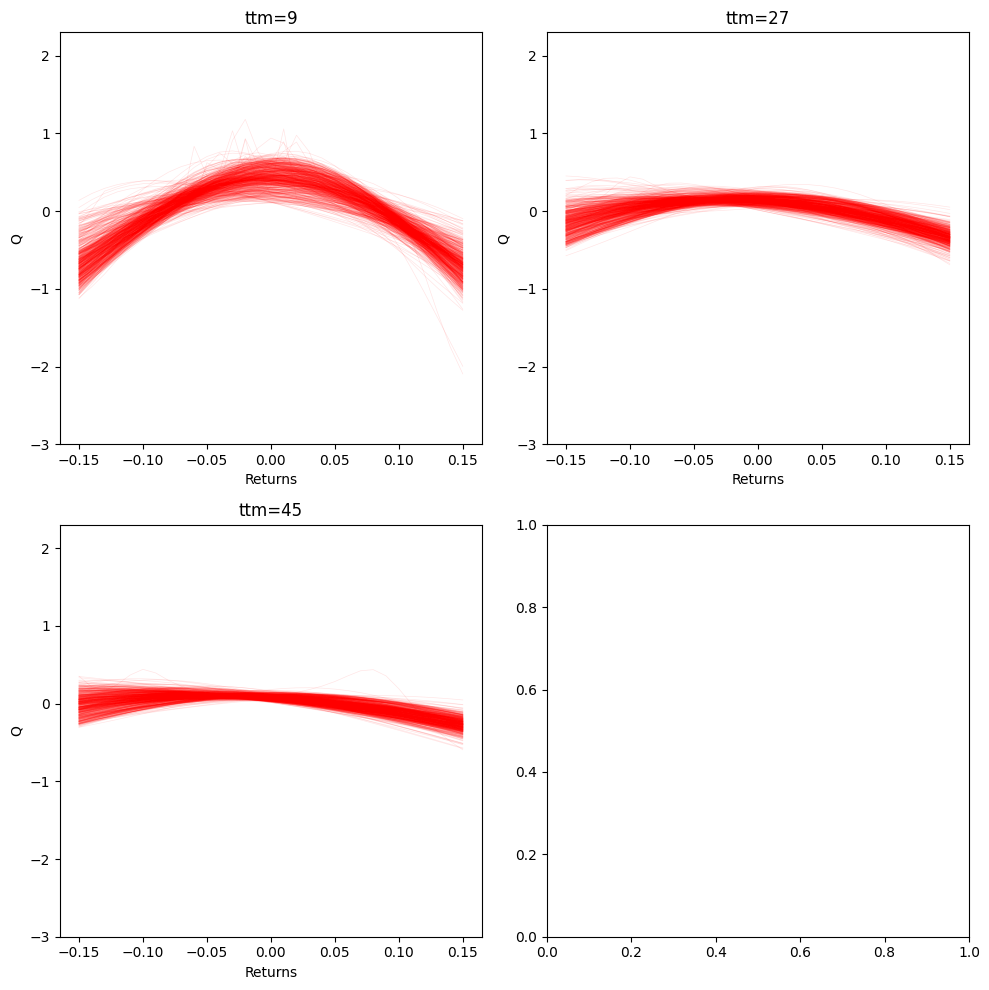

In [2]:

# =======================================================
# Plot the common Q vectors for each ttm, both clusters
# =======================================================
df1_clr_com = df1_clr[common_columns]
df2_clr_com = df2_clr[common_columns]
df3_clr_com = df3_clr[common_columns]
returns = df1['Return']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
data_frames = [df1_clr_com, df2_clr_com, df3_clr_com]
titles = ['ttm=5', 'ttm=9', 'ttm=14', 'ttm=27']
for i, (df, title) in enumerate(zip(data_frames, titles)):
    ax = axes[i//2, i%2]
    ax.plot(returns, df, color='black', linewidth=0.5, alpha=0.1)
    ax.set_xlabel('Returns')
    ax.set_ylabel('Q')
    ax.set_title(title)

    # Set y-axis limits
    ax.set_ylim(-3, 2.3)
plt.tight_layout()
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, Q_0 cluster
# =======================================================
# Find the indices of the columns where the binary array has a 1
zero_indices = np.where(ss == 1)[1]
# Select only the columns corresponding to the zero indices
selected_columns = [common_columns[i] for i in zero_indices if i < len(common_columns)]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
data_frames = [df1_clr_com, df2_clr_com, df3_clr_com]
titles = ['ttm=9', 'ttm=27', 'ttm=45']
for i, (df, title) in enumerate(zip(data_frames, titles)):
    ax = axes[i//2, i%2]
    ax.plot(returns, df[selected_columns], color='blue', linewidth=0.5, alpha=0.1)
    ax.set_xlabel('Returns')
    ax.set_ylabel('Q')
    ax.set_title(title)
    ax.set_ylim(-3, 2.3)
plt.tight_layout()
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, Q_1 cluster
# =======================================================
# Find the indices of the columns where the binary array has a 0
zero_indices = np.where(ss == 0)[1]
# Select only the columns corresponding to the zero indices
selected_columns = [common_columns[i] for i in zero_indices if i < len(common_columns)]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
data_frames = [df1_clr_com, df2_clr_com, df3_clr_com]
titles = ['ttm=9', 'ttm=27', 'ttm=45']
for i, (df, title) in enumerate(zip(data_frames, titles)):
    ax = axes[i//2, i%2]
    ax.plot(returns, df[selected_columns], color='red', linewidth=0.5, alpha=0.1)
    ax.set_xlabel('Returns')
    ax.set_ylabel('Q')
    ax.set_title(title)
    ax.set_ylim(-3, 2.3)
plt.tight_layout()
plt.show()


In [3]:
df_common_dates_cluster = pd.DataFrame({'Date': common_columns, 'Cluster': cluster_labels})
print(df_common_dates_cluster)
df_common_dates_cluster.to_csv(os.path.join(multivariate_cluster_path, "common_dates_cluster.csv"), index=False)

            Date  Cluster
0     2017-09-05        0
1     2017-09-09        0
2     2017-10-21        0
3     2018-01-05        0
4     2018-01-09        0
...          ...      ...
1060  2022-10-19        1
1061  2022-10-21        1
1062  2022-10-22        1
1063  2022-10-23        1
1064  2022-10-24        1

[1065 rows x 2 columns]
